# Описание задачи

Имеются измерения вида:

$$
y(t_{i})=u(t_{i})+v(t_{i}), \tag{1}
$$

где $u(t_{i})$― полезный сигнал, модель которого неизвестна, $v_{t_{i}}$ ― белошумная центрированная ошибка измерения. Измерения поступают с дискретностью $0.05$ сек.

Требуется построить алгоритм прогноза полезного сигнала на время 50 с, по данным $N$=4000 (200 с) предшествующих им измерений вида (1).
Для построения алгоритма предоставляется обучающая выборка измерений (1), объемом 1000 реализаций по 5000 отсчетов (250 с). Для тестирования лучшей обученной модели предоставляется тестовая выборка, объемом 500 реализаций длительностью 5000 отсчетов (250 с).

Данные представлены в датфреймах:

- `df_train` – обучающая выборка;
- `df_test` – тестовая выборка;
- `df_etalon_for_test` – истинные значения тестовой выборки без шума измерений;
- `df_etalon_for_train` – истинные значения обучающей выборки без шума измерений.

Для оценки эффективности алгоритма необходимо:

1.  Рассчитать среднее значение ошибки прогноза на время $t∈[0,50] $ по множеству реализаций тестовой выборки согласно:

        $$

    Δ \hat{u}(t_i) =\frac {1}{L} \sum(\hat{u}\_k(t_i)- u_k(t_i),\tag{2}

    $$
    где $\hat{u}_k(t_i)$  – прогноз полезного сигнала предлагаемого алгоритма для тестовой реализации номер k на время , $u_k(t_i)$ – истинные значения полезного сигнала в тестовой реализации номер k на время $t_i$,  содержащиеся в файле  etalon_for_test.csv, L=500 – количество тестовых реализаций.
    $$

2.  Рассчитать действительные среднеквадратические погрешности (СКП) ошибки прогноза по множеству реализаций тестовой выборки согласно:
    $$
    RMS(t_i) =\sqrt{ \frac {1}{L-1} \sum((\hat{u}_k(t_i)- u_k(t_i)-Δ \hat{u}(t_i) )^2},\tag{3}
    $$

# Требования к решению

Для участия в конкурсе требуется предоставить:

- Jupyter тетрадь, содержащуб код решения с пояснениями к нему;
- DataFrame со значениями средней ошибки прогноза, рассчитанной согласно (2), для моментов времени [0с, 5c, 10 с, 15 с, 25 с, 50 с], значения округлять до трех знаков после запятой. Под прогнозом на 0с подразумевается оценка процесса на момент времени последнего доступного измерения.
- DataFrame со значениями СКП прогноза, рассчитанной согласно (3), для моментов времени [5c, 10 с, 15 с, 25 с, 50 с], значения округлять до трех знаков после запятой;
- график средней ошибки (2) и ±3\*СКП (3) прогноза на каждый шаг дискретизации до 50 с.
- график с примерами реализаций прогноза на фоне истинного значения полезного сигнала для произвольных k.


In [185]:
import fireducks.pandas as pd
import numpy as np
import requests
import sklearn
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# Загрузка данных


In [186]:
df_etalon_for_test = pd.read_csv(
    "https://storage.yandexcloud.net/yanchick/etalon_for_test_t.csv", header=None
)
df_etalon_for_train = pd.read_csv(
    "https://storage.yandexcloud.net/yanchick/etalon_for_train_t.csv", header=None
)
df_test = pd.read_csv(
    "https://storage.yandexcloud.net/yanchick/test_t.csv", header=None
)
df_train = pd.read_csv(
    "https://storage.yandexcloud.net/yanchick/train_t.csv", header=None
)

In [187]:
df_etalon_for_train

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.296380,-0.34842,-0.073426,-0.30004,-0.19850,-0.45468,-0.32610,0.14199,-0.233130,0.76142,...,1.04980,0.45417,0.124360,0.28033,0.225290,0.011508,-0.61347,0.011572,0.31543,0.57673
1,0.318010,-0.31243,-0.061660,-0.29839,-0.21516,-0.44727,-0.32299,0.15155,-0.225200,0.75441,...,1.05880,0.44717,0.134350,0.30434,0.199150,0.006016,-0.59197,0.017170,0.31392,0.60063
2,0.341140,-0.27569,-0.052476,-0.29626,-0.23247,-0.43928,-0.31924,0.16185,-0.220800,0.74649,...,1.06580,0.44052,0.147490,0.32745,0.170560,0.000639,-0.56895,0.020833,0.31199,0.61754
3,0.364450,-0.23819,-0.042536,-0.29569,-0.25075,-0.42940,-0.31539,0.17567,-0.212790,0.73611,...,1.06950,0.43303,0.158970,0.34411,0.147150,-0.003763,-0.54742,0.020867,0.30744,0.63441
4,0.384080,-0.20116,-0.032056,-0.29828,-0.26976,-0.42115,-0.31340,0.18484,-0.207080,0.72489,...,1.06970,0.42463,0.171660,0.36396,0.127750,-0.007712,-0.52400,0.018665,0.29981,0.64724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.096893,0.49676,0.603260,-0.51054,-0.48883,0.74259,-0.18624,0.14120,0.010762,0.16238,...,-0.35083,0.41956,0.055188,0.47687,0.110140,-0.094176,0.83585,1.749000,-0.41960,-0.88683
4996,0.094533,0.50266,0.607840,-0.51586,-0.48177,0.73362,-0.19728,0.15699,0.023739,0.15149,...,-0.34960,0.42091,0.035827,0.45290,0.087773,-0.094094,0.82179,1.745800,-0.40292,-0.89099
4997,0.091342,0.50371,0.611830,-0.51966,-0.47221,0.72469,-0.21025,0.17241,0.038657,0.13904,...,-0.34781,0.42108,0.015498,0.42780,0.064912,-0.091975,0.80723,1.739600,-0.38625,-0.89327
4998,0.091299,0.50400,0.616440,-0.52295,-0.45846,0.71822,-0.22006,0.18666,0.052026,0.12660,...,-0.34528,0.41906,-0.001801,0.40554,0.037399,-0.094129,0.79235,1.727500,-0.36972,-0.89398


In [188]:
df_etalon_for_test

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.72607,-0.029913,-0.535790,-0.066880,0.058474,0.19787,0.41196,-0.29673,-0.38695,-0.21270,...,0.603290,0.071517,0.088562,0.70071,-1.00610,0.15891,-0.276940,0.40506,-0.74403,-0.12349
1,0.70372,-0.029792,-0.558900,-0.057671,0.047357,0.19447,0.40487,-0.30582,-0.38935,-0.19736,...,0.636940,0.082442,0.091266,0.70298,-1.00570,0.15571,-0.293280,0.37514,-0.75880,-0.13330
2,0.67788,-0.032846,-0.579570,-0.051386,0.038930,0.18895,0.40005,-0.31533,-0.39124,-0.18171,...,0.674140,0.097245,0.098298,0.70451,-1.00490,0.15144,-0.311510,0.35031,-0.77313,-0.14177
3,0.65063,-0.036704,-0.599330,-0.045810,0.024581,0.18299,0.39523,-0.32886,-0.39069,-0.16678,...,0.711800,0.114000,0.101210,0.70835,-1.00260,0.14199,-0.333010,0.33121,-0.78313,-0.14892
4,0.62493,-0.039516,-0.621040,-0.036255,0.008150,0.17853,0.39287,-0.34116,-0.39145,-0.15093,...,0.749210,0.132850,0.102070,0.70876,-1.00100,0.12775,-0.360970,0.31435,-0.79133,-0.15489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.14564,0.202830,-0.065277,0.049220,0.187660,0.41163,-0.56499,0.11873,0.32204,0.50482,...,0.072164,-0.049306,0.636400,0.48231,-0.24953,-0.39221,0.107250,0.87761,-0.66870,-0.91383
4996,0.15871,0.163070,-0.050903,0.044320,0.175350,0.42441,-0.55921,0.14031,0.32379,0.52658,...,0.060835,-0.044466,0.653640,0.48718,-0.27321,-0.38740,0.098997,0.87055,-0.67624,-0.93356
4997,0.16982,0.124790,-0.040269,0.038208,0.164020,0.43344,-0.54957,0.16035,0.32099,0.54748,...,0.051176,-0.037648,0.668870,0.49198,-0.29586,-0.37931,0.091211,0.86078,-0.68233,-0.95295
4998,0.17864,0.085922,-0.030677,0.028821,0.153490,0.44084,-0.53565,0.17726,0.31900,0.56895,...,0.039587,-0.033835,0.683810,0.49931,-0.31944,-0.37277,0.084225,0.85093,-0.68985,-0.97545


In [189]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.810800,-0.155000,0.10334,-0.525190,0.211070,-0.23937,0.372030,-0.36147,-0.50393,0.51254,...,0.724390,0.689140,-0.236600,-0.21376,1.132900,0.16308,-1.48160,0.261830,0.061188,0.522760
1,0.321070,-0.082717,1.28340,-0.067472,0.035436,0.36736,-0.386610,0.72267,-0.71206,-0.30647,...,1.335700,-0.504180,0.158010,0.32017,0.521500,-0.14125,-0.53920,0.487470,1.126900,0.746240
2,-0.011351,-0.483750,0.41724,-0.955080,-0.466710,-0.61605,-1.011200,0.11114,-1.95070,0.33820,...,0.296000,0.471210,0.991100,1.06660,0.693120,-0.12764,-0.30049,-0.082113,0.985630,1.696000
3,0.841300,-0.734990,0.39767,-0.119650,0.128510,0.07909,-0.226310,-0.56357,-0.23010,-0.10313,...,1.140800,-0.621260,0.834300,-0.33185,0.121370,0.49878,-0.58637,-0.295670,-0.234800,-0.093713
4,0.116990,-0.045413,0.82663,-0.109420,-1.352200,-0.23170,-0.419100,-0.72335,0.00019,1.18030,...,1.072200,0.801460,-0.254260,0.70588,0.464710,-0.29915,-0.81930,0.708080,0.817140,1.313900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.126800,0.853800,1.06210,0.186090,-0.074895,1.24350,0.029428,-0.78835,-0.13511,0.59199,...,-0.206550,0.085626,0.298970,0.52348,-0.136970,-0.30409,0.78232,0.884520,-1.231100,-0.840900
4996,0.647920,0.819170,2.54280,-0.830880,-1.409600,1.24090,-0.051508,1.23210,-0.10765,-1.47860,...,0.439310,0.986010,-1.297800,-0.19515,0.630800,0.27544,1.64070,2.490600,-0.280500,-1.256500
4997,0.148500,-0.033456,0.69730,-0.522140,0.208760,1.55370,-0.923770,0.96298,-0.85045,-0.50484,...,0.048966,0.953010,-0.687590,0.87318,0.126300,0.34367,1.03400,1.031600,-1.060600,-0.944310
4998,-0.974470,0.110380,0.79920,-0.893490,-0.775650,0.81969,-1.112000,-0.46740,-0.42987,0.31542,...,0.081426,0.544130,0.053445,0.97984,-0.095133,-0.24486,0.66952,1.353500,-0.570530,-1.503100


In [190]:
df_test

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.376770,0.12111,-0.73740,-0.818450,-0.44651,0.527330,1.14450,0.899400,0.157510,0.065959,...,0.770080,1.428700,-0.145030,0.431080,-0.066506,-0.659540,-1.385400,1.154800,-0.998200,-1.07090
1,0.855390,0.32434,0.38164,-0.073514,-0.64578,0.004043,-0.20932,-0.898850,0.027712,-0.558230,...,0.075201,0.571830,-0.011912,0.831250,-1.199800,0.107810,-0.332140,0.980850,-1.588200,-0.43049
2,0.737680,-0.36553,-0.71093,-0.132370,0.24580,0.021259,0.49430,-1.165000,-0.962640,-0.638850,...,1.006700,0.561980,0.341200,1.319700,-0.206550,0.871560,-1.234700,0.452090,-1.249300,-0.11823
3,-0.070989,0.41646,-0.71650,-0.111780,-0.81889,-0.391400,0.32478,-0.008621,-0.103210,-0.044321,...,0.095421,0.371570,-0.252240,0.178780,-1.841000,0.252360,-0.532370,1.475400,-0.253440,-0.74512
4,0.106900,0.72321,-0.56408,-0.140060,0.58093,-0.145180,0.35215,0.022111,-0.763960,-0.883120,...,1.612900,0.008878,0.838780,1.237700,-0.747490,0.499770,0.329240,-0.306550,-1.928600,-0.14567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.413290,0.37904,-0.16287,0.377520,1.23530,0.517560,-0.26511,0.347900,-0.181420,1.028800,...,1.353900,-1.014800,0.930980,0.159710,-0.272790,-0.673780,0.113820,1.075200,-0.741870,-0.73384
4996,-0.147480,0.51969,-0.69086,-0.010957,-0.18977,0.640510,-1.17130,0.946330,0.291340,0.725270,...,-0.397220,-0.112230,0.137930,0.086913,-0.408420,-0.142480,0.318820,0.062271,-0.263190,-1.15010
4997,0.400770,1.70300,-0.23644,-0.771730,-0.52466,-0.047739,-1.11260,-0.050508,0.830350,-0.328280,...,1.239200,-0.521910,0.758260,1.339100,-0.540280,0.000052,0.450050,1.361000,-1.241700,-1.63340
4998,1.049600,-0.78243,0.42602,1.057300,-0.56242,0.556510,-0.72602,-0.063966,0.752480,0.786540,...,0.566270,0.423910,0.883410,0.913270,-0.517560,-1.051400,-0.075777,0.979740,1.157400,-0.31439


In [191]:
print(df_train.isnull().sum().sum())
print(df_etalon_for_train.isnull().sum().sum())

0
0


In [192]:
random_state = 68

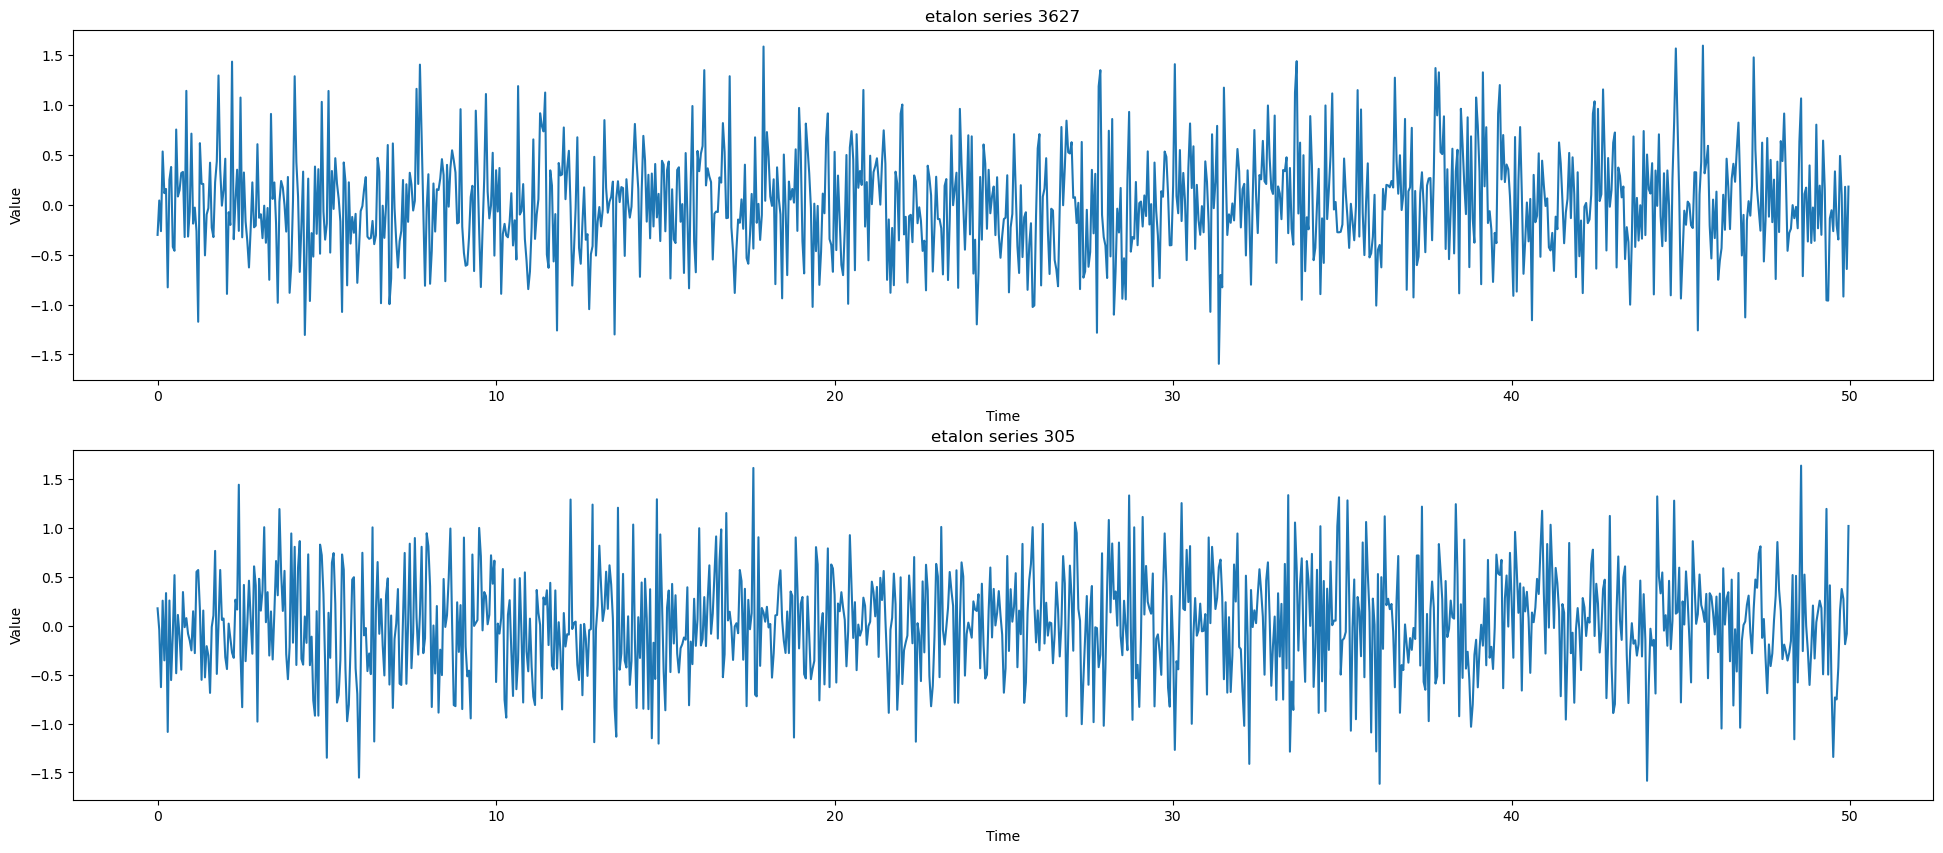

In [193]:
# show some
shape = (2, 1)
some_el_train = df_etalon_for_train.sample(
    n=shape[0] * shape[1], random_state=random_state
)

fig, ax = plt.subplots(*shape, figsize=(24, 10))
if shape[1] == 1:
    ax = [ax]

time = np.arange(0, 50, 0.05)
for i, r in enumerate(ax):
    for j, p in enumerate(r):
        p.plot(time, some_el_train.iloc[i * shape[1] + j])
        p.set_title(f"etalon series {some_el_train.iloc[i * shape[1] + j].name}")
        p.set_xlabel("Time")
        p.set_ylabel("Value")


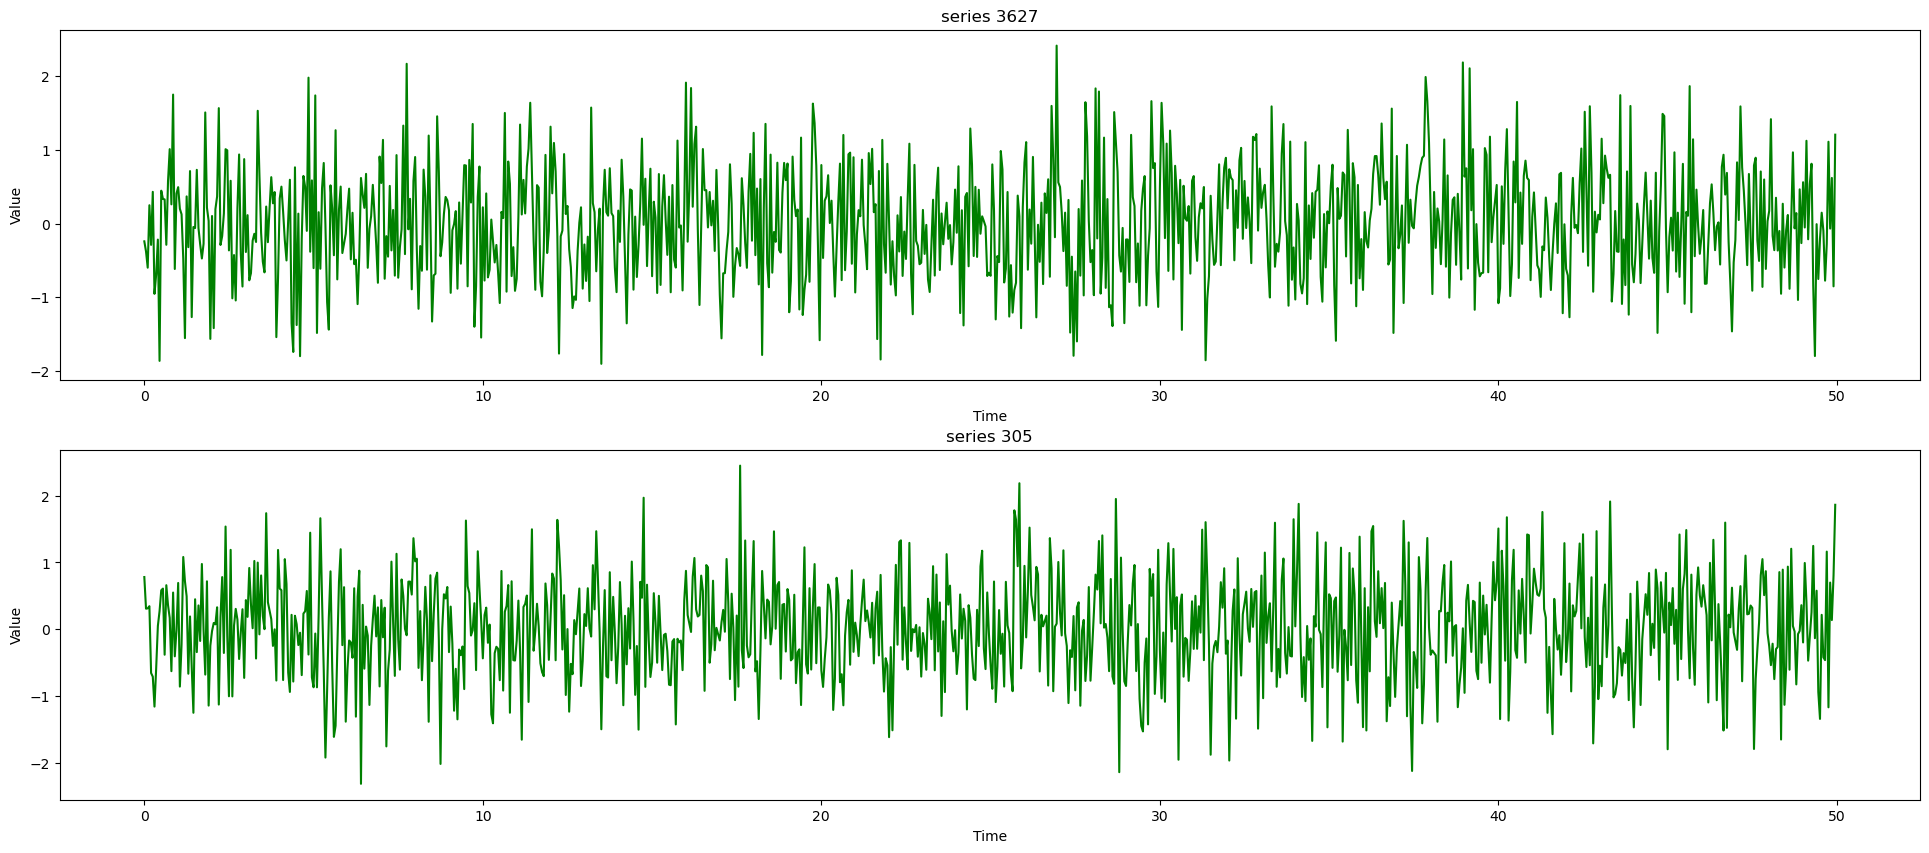

In [194]:
# show some

some_train = df_train.sample(n=shape[0] * shape[1], random_state=random_state)

fig, ax = plt.subplots(*shape, figsize=(24, 10))
if shape[1] == 1:
    ax = [ax]

time = np.arange(0, 50, 0.05)
for i, r in enumerate(ax):
    for j, p in enumerate(r):
        p.plot(time, some_train.iloc[i * shape[1] + j], "g")
        p.set_title(f"series {some_train.iloc[i * shape[1] + j].name}")
        p.set_xlabel("Time")
        p.set_ylabel("Value")


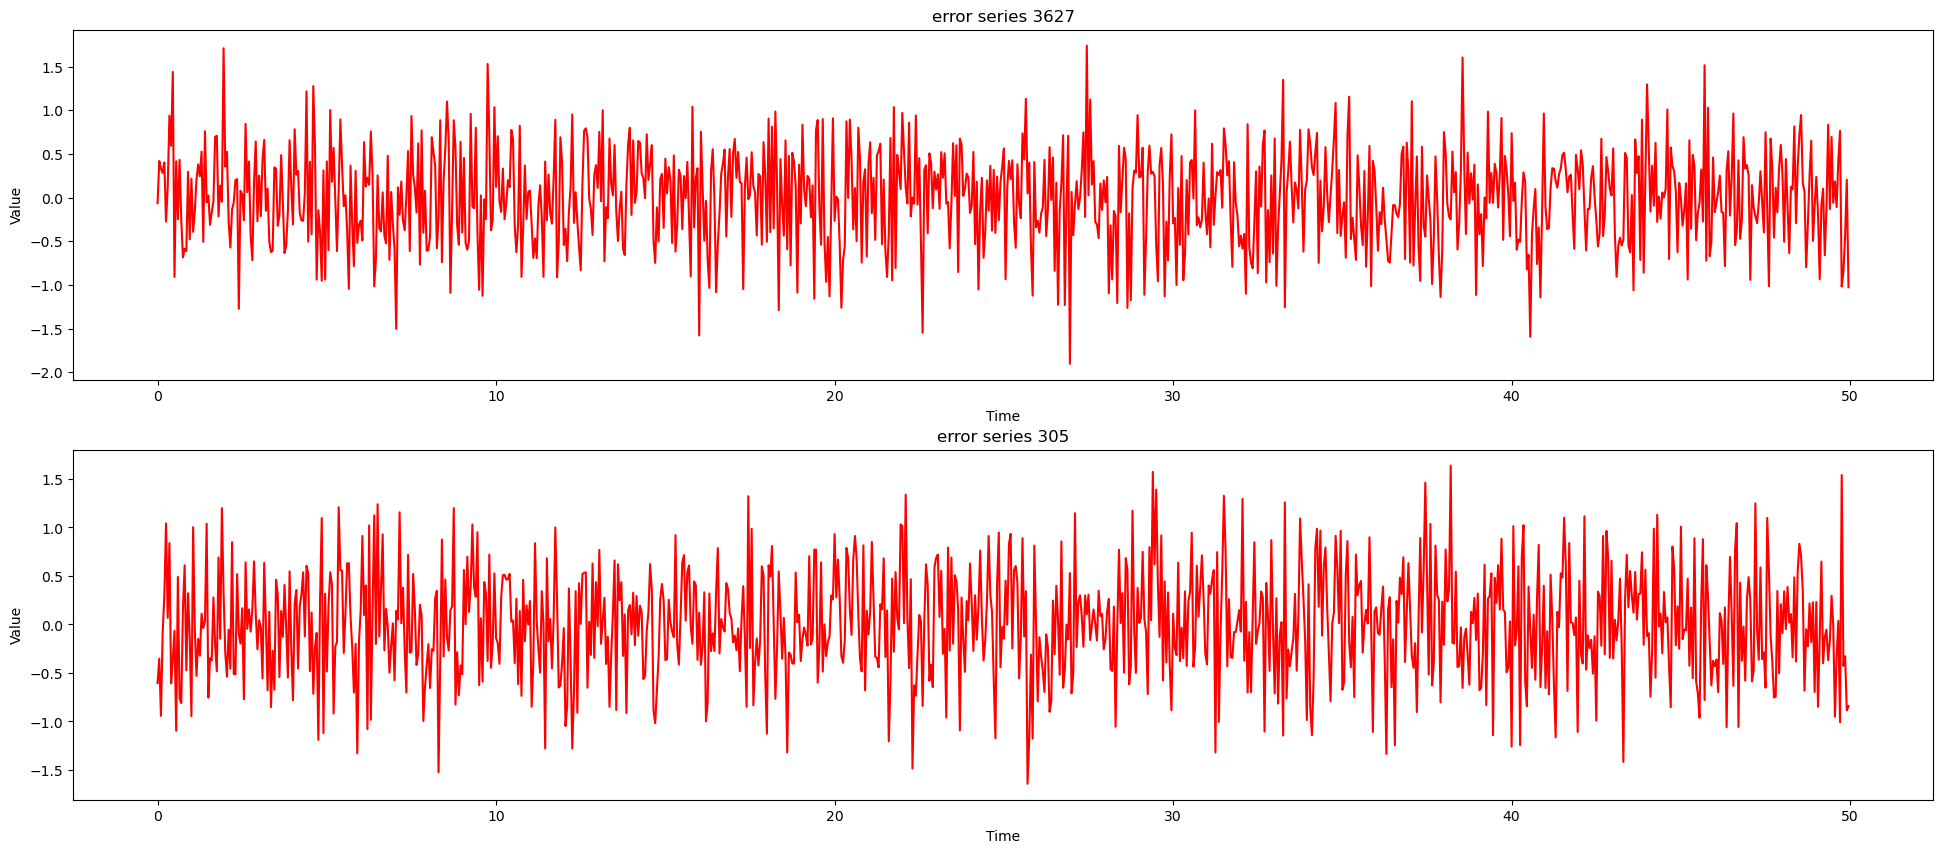

In [195]:
# error function

fig, ax = plt.subplots(*shape, figsize=(24, 10))
if shape[1] == 1:
    ax = [ax]

time = np.arange(0, 50, 0.05)
for i, r in enumerate(ax):
    for j, p in enumerate(r):
        p.plot(
            time,
            some_el_train.iloc[i * shape[1] + j] - some_train.iloc[i * shape[1] + j],
            "r",
        )
        p.set_title(f"error series {some_train.iloc[i * shape[1] + j].name}")
        p.set_xlabel("Time")
        p.set_ylabel("Value")

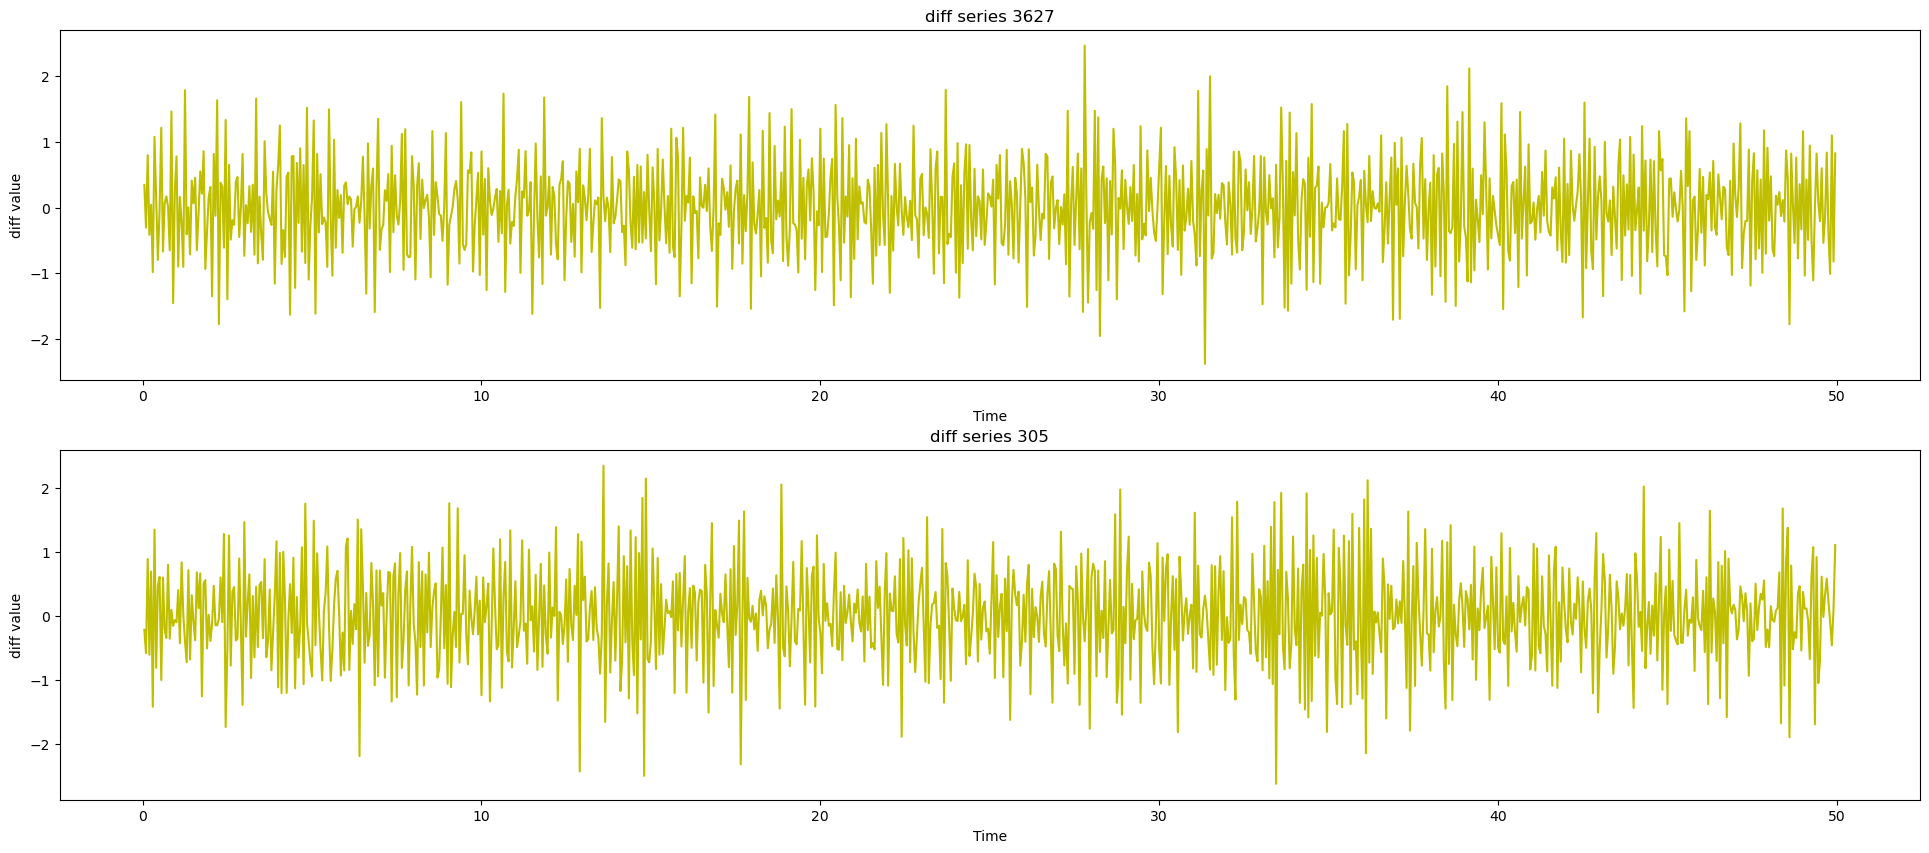

In [196]:
# diff

fig, ax = plt.subplots(*shape, figsize=(24, 10))
if shape[1] == 1:
    ax = [ax]

time = np.arange(0, 50, 0.05)
for i, r in enumerate(ax):
    for j, p in enumerate(r):
        p.plot(time, some_el_train.iloc[i * shape[1] + j].diff(), "y")
        p.set_title(f"diff series {some_train.iloc[i * shape[1] + j].name}")
        p.set_xlabel("Time")
        p.set_ylabel("diff value")

In [197]:
# col correlation
corr = df_etalon_for_train.corr()
# plt.figure(figsize=(128, 128))
# sns.heatmap(
#     corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values
# )

In [198]:
# row correlation
corr = corr.T
# plt.figure(figsize=(128, 128))
# sns.heatmap(
#     corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values
# )

# Предобработка данных


In [199]:
X_f = [i for i in range(500)]
Y_f = [i for i in range(500, 1000)]


In [219]:
class SeriesDataset(Dataset):
    def __init__(self, data, etalon_data, etalon=True):
        self.data = data
        self.etalon_data = data
        self.etalon = etalon
        self.X_f = [i for i in range(500)]
        self.Y_f = [i for i in range(500, 1000)]

        self.X = self.data[self.X_f]
        self.Y = self.data[self.Y_f]
        self.X_e = self.etalon_data[self.X_f]
        self.Y_e = self.etalon_data[self.Y_f]

    def __len__(self):
        if self.etalon:
            return len(self.etalon_data.index)
        return len(self.data.index)

    def __getitem__(self, idx: int):
        if self.etalon:
            return torch.tensor(self.X_e.iloc[idx].to_numpy()), torch.tensor(
                self.Y_e.iloc[idx].to_numpy()
            )
        return torch.tensor(self.X.iloc[idx].values), torch.tensor(
            self.Y.iloc[idx].values
        )


sdataset = SeriesDataset(df_train, df_etalon_for_train)
dataloader = DataLoader(sdataset, batch_size=1000, shuffle=True)

train_val_size = [0.9, 0.1]
train_d, val_d = random_split(sdataset, train_val_size)
train_l , val_l = DataLoader(train_d, batch_size=500) , DataLoader(val_d, batch_size=500)



# Исследовательский анализ данных и синтез признакова


In [201]:
# Проверка на стационарность    (ADF-test) (нет, если да ARIMA)
# Проверка на нормальность      (Преобразование Бокса-Кокса)

In [202]:
# Попробовать увеличить размер датасета добавив все ошибки к каждому случаю.
# Тренд, сезонность, цыклы      (Вроде как их нет так что можно не проверять)

In [214]:
# Лаг
# Автокореляция

# Обучение моделей


In [228]:
class SARIMAModel(nn.Module):
    def __init__(self, input_size=500, output_size=500, hidden_size=128):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.linear1(x))
        return self.linear2(x)


model = SARIMAModel()

In [229]:
# train model
def train_model(model, dataloader, epoch=3, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    criterion = nn.MSELoss(1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epoch):
        model.train()
        total_loss = 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.float().to(device), targets.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader):.4f}")


train_model(model, train_l)

cuda
Epoch 1, Loss: 0.5913
Epoch 2, Loss: 0.5553


KeyboardInterrupt: 

In [ ]:
# validate model
def validate_model(model, test_loader):
    device = next(model.parameters()).device
    model.eval()
    predictions = []
    targets_list = []

    criterion = nn.MSELoss()
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.float().to(device)
            preds = model(inputs).cpu().numpy()
            predictions.append(preds)
            targets_list.append(targets.numpy())

    return criterion(np.concatenate(predictions), np.concatenate(targets_list))


validate_model(model, val_l)

# Ответы на задания
